# A Work in Progress Recurrent Neural Network

The dataset given has the normalized optical density (OD<sub>600</sub>) as a function of antibacterial activity (growth inhibition). To use a recurrent neural network, there needs to be a multiple to one relationship between antibacterial activity to OD. To do this, 2 discrete bins were created to classify compounds as active (1) or inactive (0) with a threshold of OD<sub>600</sub> < 0.2 to define growth inhibitory activity. While this is not completely physical, it was used to move forward with progress. More bins will capture more accurate physics however there will be less data associated with each bin for training. Another drawback for this method is it places a bound on the data being classified. It is possible for a chemical composition to produce an OD<sub>600</sub> outside of the established range but this ML algorithm will not properly predict this.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time
import math

Not actually used in this version, but an alternative method for processing SMILES data considered:
- use a package called [SmilesPE](https://github.com/XinhaoLi74/SmilesPE/tree/master) to tokenize SMILES data to manipulate instead of generating feature vectors
- installation: `pip install SmilesPE`

In [ ]:
# from SmilesPE.pretokenizer import atomwise_tokenizer
# from SmilesPE.pretokenizer import kmer_tokenizer
# smi_atom = 'CC[N+](C)(C)Cc1ccccc1Br' # tokenizes by atoms 
# toks_atom = atomwise_tokenizer(smi_atom)
# print(toks_atom)

# smi_kmer = 'CC[N+](C)(C)Cc1ccccc1Br' # tokenizes by k-mers
# toks_kmer = kmer_tokenizer(smi_kmer)
# print(toks_kmer)

Moving on, let's first extract data from a dataset obtained from the paper [A Deep Learning Approach to Antibiotic Discovery](https://doi.org/10.1016/j.cell.2020.01.021), which contains molecule entries in SMILES format with their normalized OD<sub>600</sub> values given as "mean inhibition".

In [2]:
# extract the data 
data = pd.read_csv('bin_data.csv',keep_default_na=False,header=1)
smiles = data['SMILES'] # SMILES is the header of the SMILES column
categories = data['Activity'] # Activity is the header of the Bin column

In order to translate SMILES characters to numbers, the characters are tokenized and the arranged in a string. Each token’s index becomes the associated number which can then be fed into pytorch.

Alternative tokenization methods are possible however they were not utilized due to time limitations. SMILES molecules can be tokenized by atoms or k-mers which may improve accuracy. 

In [3]:
smiles_concat=''.join(str(smiles)) # Join all the SMILE strings together

*if using SmilesPE package, SmilesPE tokenizer would be used here:*

`toks=atomwise_tokenizer(smiles_concat)`

In [5]:
all_chars=''.join(set(smiles_concat)) # Extract unique characters from combined SMILE strings into a set and then joining as a string
n_chars=len(all_chars)

In [20]:
categories_set=set(categories)
n_categories=len(categories_set)
all_categories=list(categories_set)
all_categories.reverse()
print('all_categories type:', type(all_categories))
print('All categories:', all_categories)
print('Number of categories:',n_categories)

all_categories type: <class 'list'>
All categories: ['Inactive', 'Active']
Number of categories: 2


In [21]:
# Find character index from all_chars
def charToIndex(char):
    return all_chars.find(char)

In [22]:
# turn a character into a <1 x n_chars> Tensor
def charToTensor(char):
    tensor = torch.zeros(1, n_chars)
    tensor[0][charToIndex(char)] = 1
    return tensor

In [23]:
# Turn a line into a <line_length x 1 x n_chars>,
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_chars)
    for li, letter in enumerate(line):
        tensor[li][0][charToIndex(line)] = 1
    return tensor

In [24]:
print(charToTensor('C'))
print(smiles[0])
print(lineToTensor('Cl.NC1=NCC2N1C1=C(CC3=C2C=CC=C3)C=CC=C1').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0.]])
Cc1cc(O)c(C(=O)NC(C(=O)NC2C(=O)N3C(C(=O)O)=C(CSc4nnnn4C)CSC23)c2ccc(O)cc2)cn1
torch.Size([39, 1, 42])


In [25]:
# now implement a recurrent neural network
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [26]:
n_hidden = 100
rnn = RNN(n_chars, n_hidden, n_categories)

input = lineToTensor('Cl.NC1=NCC2N1C1=C(CC3=C2C=CC=C3)C=CC=C1')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-0.7078, -0.6787]], grad_fn=<LogSoftmaxBackward0>)


In [27]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Active', 1)


In [28]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    ind_category=data.index[data['Activity'] == category].tolist()
    ind_random=randomChoice(ind_category)
    line = smiles[ind_random]
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [29]:
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Inactive / line = O=C(O)C1C(=CCO)OC2CC(=O)N21.[LiH]
category = Inactive / line = COc1ccccc1-c1cc(=O)c2c(OC)cccc2o1
category = Active / line = CC1CCc2c(N3CCC(O)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23
category = Inactive / line = CC1=CCCC(C)=CCC(C)(C)C=CC1
category = Inactive / line = CN(C)C(=N)NC(=N)N.Cl
category = Active / line = COC1C=COC2(C)Oc3c(C)c(O)c4c(O)c(c(C=NN5CCN(C6CCCC6)CC5)c(O)c4c3C2=O)NC(=O)C(C)=CC=CC(C)C(O)C(C)C(O)C(C)C(OC(C)=O)C1C
category = Active / line = COc1cc2c(cc1OC)C(=O)C(CC1CCN(Cc3ccccc3)CC1)C2.Cl
category = Active / line = COC1(NC(=O)C2SC(=C(C(N)=O)C(=O)O)S2)C(=O)N2C(C(=O)O)=C(CSc3nnnn3C)CSC21
category = Active / line = CC1CCc2cc(F)cc3c(=O)c(C(=O)O)cn1c23
category = Active / line = CCC=C(C(=O)NC1C(=O)N2C(C(=O)OCOC(=O)C(C)(C)C)=C(COC(N)=O)CSC12)c1csc(N)n1.Cl


In [30]:
criterion = nn.NLLLoss()

learning_rate = 0.001 # If you set this too high, it might explode. If too low, it might not learn

In [31]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [32]:
n_iters = 25000 # initialize number of iterations to train
print_every = 1000 # print prediction and whether or not its successful every 1000 iterations
plot_every = 500 # plot prediction error every 500 iterations

# Keep track of losses for plotting
current_loss = 0
all_losses = []

In [33]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [34]:
start = time.time()

1000 4% (0m 8s) 0.7418 CC12CCC(=O)C=C1C=CC1C2CCC2(C)C1CCC21CCC(=O)O1 / Active ✗ (Inactive)
2000 8% (0m 11s) 0.7679 Cl.NC(COP(=O)(O)O)C(=O)O / Active ✗ (Inactive)
3000 12% (0m 15s) 0.6935 CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNCC3)cc21 / Inactive ✗ (Active)
4000 16% (0m 18s) 0.7057 COc1c2ccoc2c(OC)c2oc(=O)ccc12 / Active ✗ (Inactive)
5000 20% (0m 21s) 0.7125 Cl.NCC(CC(=O)O)c1ccc(Cl)cc1 / Active ✗ (Inactive)
6000 24% (0m 25s) 0.7204 CCOC(=O)OC(C)OC(=O)C1N2C(=O)C(NC(=O)C(N)c3ccccc3)C2SC1(C)C.Cl / Inactive ✗ (Active)
7000 28% (0m 28s) 0.6537 O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O / Inactive ✓
8000 32% (0m 32s) 0.6836 C#CCCCCCCCCCCCC(O)CC(O)CO / Inactive ✓
9000 36% (0m 35s) 0.6820 O=C(NC(CO)C(O)c1ccc([N+](=O)[O-])cc1)C(Cl)Cl / Active ✓
10000 40% (0m 38s) 0.7425 COc1c2ccoc2nc2c(OC)c(OCC(O)C(C)(C)O)ccc12 / Active ✗ (Inactive)
11000 44% (0m 42s) 0.7011 O=c1[nH]cc(F)c(=O)[nH]1 / Active ✗ (Inactive)
12000 48% (0m 45s) 0.7850 CCCCCCCCCCCCCCCC[n+]1ccccc1.[Cl-] / Inactive ✗ (Active)
13000 52% (0

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

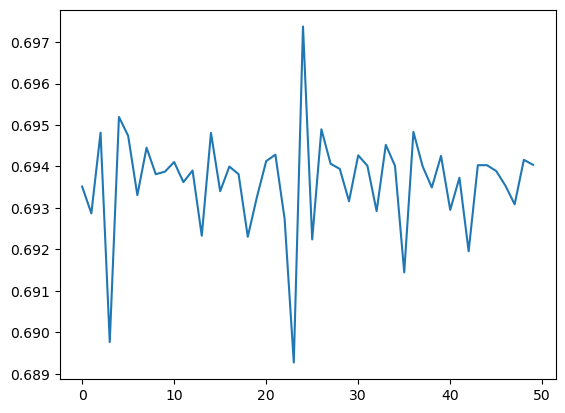

In [35]:
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
plt.plot(all_losses)
plt.xlabel

In [36]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=1):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [37]:
# now that model is trained, make predictions

predict('CCS(=O)(=O)C1=NC=C(CN(C)C2CCCCC2)N1CC1=CC=CC=C1')
print('Correct Bin: Inactive')
predict('Cl.COC1=CC=C(OC)C(=C1)C(O)C(C)N')
print('Correct Bin: Inactive')
predict('[Na+].NC1=CC=C(C=C1)S(=O)(=O)[N-]C1=NC2=CC=CC=C2N=C1')
print('Correct Bin: Inactive')
predict('CC(C)(C)C1=CC=C(C=C1)C(=O)CCCN1CCC(CC1)OC(C1=CC=CC=C1)C1=CC=CC=C1')
print('Correct Bin: Inactive')
predict('Cl.CN(C)[C@H]1[C@@H]2C[C@@H]3[C@H](O)C4=C(Cl)C=CC(O)=C4C(=O)C3=C(O)[C@]2(O)C(=O)C(C(N)=O)=C1O')
print('Correct Bin: Active')


> CCS(=O)(=O)C1=NC=C(CN(C)C2CCCCC2)N1CC1=CC=CC=C1
(-0.68) Active
Correct Bin: Inactive

> Cl.COC1=CC=C(OC)C(=C1)C(O)C(C)N
(-0.68) Active
Correct Bin: Inactive

> [Na+].NC1=CC=C(C=C1)S(=O)(=O)[N-]C1=NC2=CC=CC=C2N=C1
(-0.68) Active
Correct Bin: Inactive

> CC(C)(C)C1=CC=C(C=C1)C(=O)CCCN1CCC(CC1)OC(C1=CC=CC=C1)C1=CC=CC=C1
(-0.68) Active
Correct Bin: Inactive

> Cl.CN(C)[C@H]1[C@@H]2C[C@@H]3[C@H](O)C4=C(Cl)C=CC(O)=C4C(=O)C3=C(O)[C@]2(O)C(=O)C(C(N)=O)=C1O
(-0.68) Active
Correct Bin: Active


While this algorithm has a long way to go to achieve reliability, it is capable of predicting better than 10% (random guessing) after enough training.